Dataset: [Car Evaluation Dataset](https://www.kaggle.com/datasets/stealthtechnologies/car-evaluation-classification)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df_car = pd.read_csv("/content/cars.csv")
df_car.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


**EDA**

In [23]:
df_car.dtypes

,0
buying,object
maint,object
doors,object
persons,object
lug_boot,object
safety,object
class,object


In [ ]:
df_cols = df_car.columns
df_cols

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(15,8))
axes = axes.flatten()

for i, column in enumerate(df_cols):
  sns.countplot(data=df_car, x=column, hue="class", ax=axes[i])

for ax in axes[df_cols.size:]:
  ax.axis("off")

plt.tight_layout()
plt.show()

In [22]:
df_car["class"].value_counts()

,count
class,
unacc,1210
acc,384
good,69
vgood,65


**Codificación de variables categóricas**

In [ ]:
!pip install category-encoders

In [ ]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=df_car.columns)
df_car_encoded = encoder.fit_transform(df_car)
df_car_encoded.head(10)

In [62]:
encoder.mapping

[{'col': 'buying',
  'mapping': vhigh    1
  high     2
  med      3
  low      4
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'maint',
  'mapping': vhigh    1
  high     2
  med      3
  low      4
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'doors',
  'mapping': 2        1
  3        2
  4        3
  5more    4
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'persons',
  'mapping': 2       1
  4       2
  more    3
  NaN    -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'lug_boot',
  'mapping': small    1
  med      2
  big      3
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'safety',
  'mapping': low     1
  med     2
  high    3
  NaN    -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 'class',
  'mapping': unacc    1
  acc      2
  vgood    3
  good     4
  NaN     -2
  dtype: int64,
  'data_type': dtype('O')}]

**Entrenar el modelo**

In [ ]:
X = df_car_encoded.drop("class", axis=1)
y = df_car_encoded["class"]
X, y

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_train.value_counts()

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
y_train_resampled.value_counts()

In [105]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=8, random_state=42)

**Evaluación del modelo**

In [106]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [107]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f'El accuracy en train es: {train_acc}')
print(f'El accuracy en test es: {test_acc}')

El accuracy en train es: 0.9594706368899917
El accuracy en test es: 0.9364161849710982


<ipython-input-108-29a7d39f8732>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=importances, palette="bright")


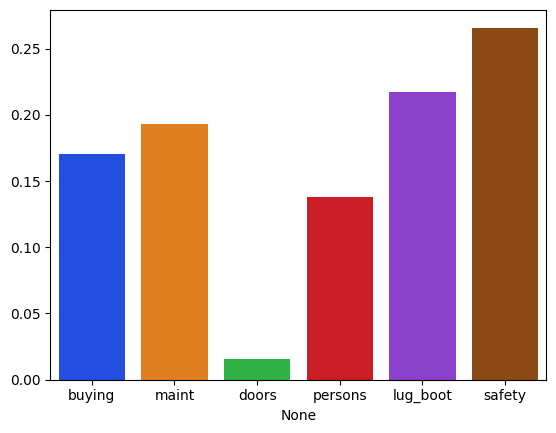

In [108]:
importances = clf.feature_importances_
sns.barplot(x=X.columns, y=importances, palette="bright")
plt.show()

In [109]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

[[350   8   0   0]
 [  0  95   5  18]
 [  0   0  24   0]
 [  0   0   2  17]]


In [103]:
# unacc    1
# acc      2
# vgood    3
# good     4
# NaN     -2
clf.classes_

array([1, 2, 3, 4])

[Text(0.5, 0.75, 'safety <= 1.5\ngini = 0.75\nsamples = 100.0%\nvalue = [0.25, 0.25, 0.25, 0.25]\nclass = unacceptable'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 11.9%\nvalue = [1.0, 0.0, 0.0, 0.0]\nclass = unacceptable'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.736\nsamples = 88.1%\nvalue = [0.148, 0.284, 0.284, 0.284]\nclass = acceptable'),
 Text(0.625, 0.5, '  False')]

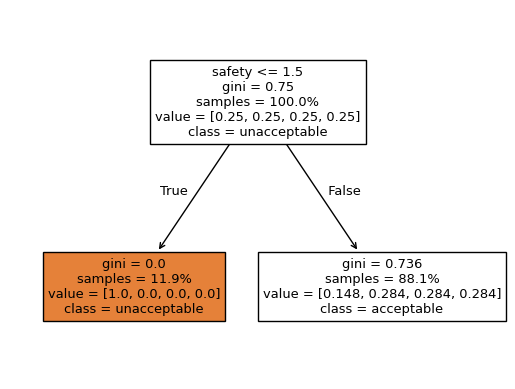

In [104]:
from sklearn import tree
tree.plot_tree(clf, feature_names=X.columns, class_names=["unacceptable", "acceptable", "very good", "good"], proportion=True, filled=True)

**Overfitting**

In [90]:
def train_and_evaluate(max_depth):
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
  clf.fit(X_train_resampled, y_train_resampled)

  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)

  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)

  return train_acc, test_acc

In [ ]:
depths_range = np.arange(1,20)
train_scores = []
test_scores = []

for i in depths_range:
  train_score, test_score = train_and_evaluate(i)

  train_scores.append(train_score)
  test_scores.append(test_score)
# train_scores, test_scores

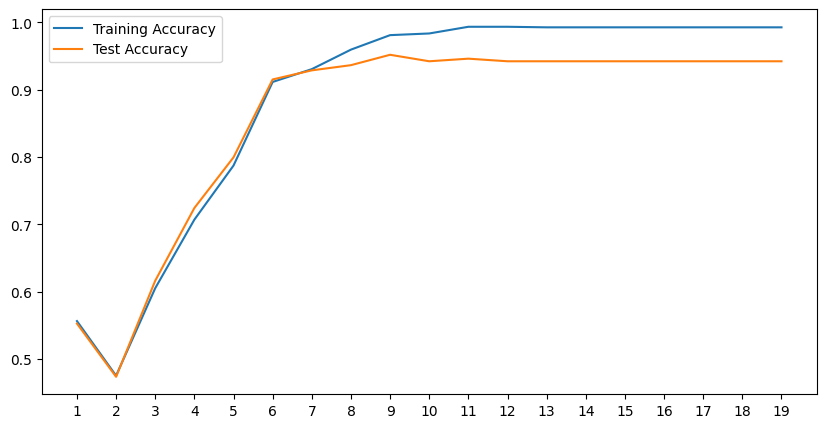

In [97]:
plt.figure(figsize=(10,5))
plt.plot(depths_range, train_scores, label="Training Accuracy")
plt.plot(depths_range, test_scores, label="Test Accuracy")
plt.xticks(depths_range)
plt.legend()
plt.show()